# Fine tuning resnet

In [16]:
device = "cuda"

In [57]:
import csv

import cv2
import numpy as np
import torch


class AnimalsDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        
        samples = []
        with open(f"{root}/dataset.csv", "r") as f:
            reader = csv.DictReader(f)
            for line in reader:
                samples.append(line)
        self.samples = samples

    def __getitem__(self, idx):
        sample = self.samples[idx]

        full_path = f"{self.root}/{sample['image_path']}"
        image = cv2.imread(full_path)
        image = image.transpose(2, 0, 1)
        image = torch.as_tensor(image)

        class_label = int(sample["class_label"])
        label = np.zeros((10,))
        label[class_label] = 1
        label = torch.as_tensor(label)

        if self.transforms:
            image = self.transforms(image)

        return image, label

    def __len__(self):
        return len(self.samples)

In [62]:
from torchvision.models import resnet50, ResNet50_Weights

model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
transforms = ResNet50_Weights.IMAGENET1K_V2.transforms()

# uncomment these lines to freeze the pretrained parameters
# for param in model.parameters():
#     param.requires_grad = False

# update the last layer to output 10 classes
model.fc = torch.nn.Linear(in_features=2048, out_features=10, bias=True)
model = model.to(device)

In [39]:
dataset = AnimalsDataset("data/train", transforms)
dataset[0]

(tensor([[[ 1.9578,  2.0263,  1.7180,  ..., -1.1075, -1.5870, -0.7137],
          [ 2.0948,  1.9920,  0.7933,  ..., -0.9363, -1.3644, -0.8849],
          [ 2.0092,  1.1872, -0.2342,  ..., -1.0048, -1.6727, -1.5357],
          ...,
          [ 1.6838,  1.3070,  0.8789,  ...,  2.0948,  1.7865,  0.8618],
          [ 1.6324,  0.8447, -0.0458,  ...,  1.6838,  1.5125,  0.7591],
          [ 1.7180,  0.4851, -0.7479,  ...,  1.3242,  1.7352,  0.8447]],
 
         [[ 2.2710,  2.3936,  2.1485,  ..., -0.1800, -0.4951,  0.5553],
          [ 2.4111,  2.3585,  1.1856,  ...,  0.1527, -0.0749,  0.5903],
          [ 2.3410,  1.5357,  0.1176,  ...,  0.2052, -0.2500,  0.0476],
          ...,
          [ 2.0084,  1.5707,  1.1155,  ...,  2.2885,  1.9734,  1.0280],
          [ 2.0084,  1.1331,  0.2227,  ...,  1.8508,  1.6758,  0.9230],
          [ 2.1485,  0.8529, -0.4251,  ...,  1.5182,  1.9559,  1.0455]],
 
         [[ 2.5180,  2.6226,  2.3960,  ...,  0.2871, -0.1835,  0.6705],
          [ 2.6226,  2.5703,

In [48]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

# use the below line to train only the last layer
# optimizer = torch.optim.Adam(params=model.fc.parameters())

In [41]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True, num_workers=2)

# For Training
image, target = next(iter(data_loader))
image, target = image.to(device), target.to(device)

output = model(image)   # Returns losses and detections
print(output)

loss = loss_fn(output, target)
print(loss)

tensor([[ 0.0335,  0.0684, -0.0370, -0.0123, -0.0306, -0.0408,  0.0202,  0.0228,
          0.0637, -0.0151],
        [ 0.1242, -0.0175, -0.0690, -0.0635,  0.1255, -0.0322,  0.0118, -0.0193,
         -0.0005, -0.0508]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor(2.2529, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)


In [42]:
def train_one_epoch(model, criterion, optimizer, data_loader, epoch):

    header = f"Epoch: [{epoch}]"
    losses = []
    for i, (image, target) in enumerate(data_loader):
        image, target = image.to(device), target.to(device)

        output = model(image)
        loss = criterion(output, target)

        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    print("The average loss for the epoch is: ", sum(losses) / len(losses))

In [ ]:
for epoch in range(5):

    train_one_epoch(model, loss_fn, optimizer, data_loader, epoch)


The average loss for the epoch is:  2.224212915325447
The average loss for the epoch is:  2.2198730120965204
The average loss for the epoch is:  2.2188444037606305


In [44]:
from torch.utils.data import DataLoader

test_dataset = AnimalsDataset("data/test", transforms)
test_data_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)

In [45]:
def test(model, data_loader):
    correct = 0
    for i, (image, target) in enumerate(data_loader):
        image, target = image.to(device), target.to(device)

        output = model(image)

        pred = torch.argmax(output)
        true = torch.argmax(target)

        if pred == true:
            correct += 1
    
    acc = round(correct / len(data_loader) * 100, 2)
    print(f"The Accuracy of the model is: {acc}%")

test(model, test_data_loader)

The Accuracy of the model is: 18.61%


# K-Means clustering

In [ ]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.fc.register_forward_hook(get_activation("fc"))

In [75]:
model.eval()

data = []
for idx, (image, target) in enumerate(data_loader):
    image, target = image.to(device), target.to(device)

    out = model(image)

    data.append(activation["fc"].cpu().numpy().squeeze())

    if idx == 100:
        break

In [76]:
from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters=10).fit(data)

In [84]:
model.eval()

x = []
y = []
c = []
for idx, (image, target) in enumerate(test_data_loader):
    image, target = image.to(device), target.to(device)

    out = model(image)

    x_data = activation["fc"].cpu().numpy().astype("float")

    cluster = kmeans.predict(x_data)
    
    x.append(x_data[0][0])
    y.append(x_data[0][1])
    c.append(cluster)

    if idx == 100:
        break

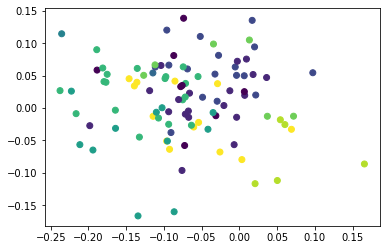

In [85]:
import matplotlib.pyplot as plt


plt.scatter(x, y, c=c)